import libraries

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hydroeval as he

model library

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

hyper parameter tuner

In [96]:
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


loss test

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


load dataset

In [24]:
# def load_dataset(path):
#     return pd.read_csv(path)


# file_path = r"C:\Users\Acer\Desktop\Testing\preprocessed_dataset.csv"
# df= load_dataset(file_path)

# df

features define

In [25]:
# import datetime

# def str_to_datetime(s):
#     split = s.split('/')
#     month,day,year = int(split[0]),int(split[1]),int(split[2])

#     return datetime.datetime(year=year,month=month,day=day)

In [98]:
df = pd.read_csv('preprocessed_dataset_china.csv',index_col=0)


In [99]:
df.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
3/1/2013 0:00,0.006024,0.172689,0.297909,0.646749,0.255486,0.0
3/1/2013 1:00,0.008032,0.183869,0.290941,0.655536,0.250784,0.0
3/1/2013 2:00,0.005020,0.164304,0.282230,0.659051,0.244514,0.0
3/1/2013 4:00,0.005020,0.100020,0.277003,0.685413,0.213166,0.0
3/1/2013 5:00,0.007028,0.178279,0.264808,0.695958,0.222571,0.0


In [100]:
features = ["PM2.5",	"O3",	"TEMPERATURE",	"PRESSURE",	"DEWPOINT", 	"RAIN"]
df = df[features]

In [101]:
import numpy as np

mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm

threshold = 3
df = df[np.abs(z_scores) < threshold]

adding window 

In [102]:


def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df,WINDOW_SIZE)

X.shape, y.shape
     

((33038, 2, 6), (33038,))

import

In [103]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers

Developing transformer model

In [104]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model

In [105]:
input_shape = X.shape[1:]
input_shape

(2, 6)

importing for training

In [106]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

Model Building

In [107]:

input_shape = X.shape[1:]


best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')


outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=3,

        directory = f'C:/Users/Dell/Desktop/MP/tr tuning china/Hp_Tr_China/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
        project_name = f'C:/Users/Dell/Desktop/MP/tr tuning china/Hp_Tr_China/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
        )

        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_squared_error(y_val, y_pred)

        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model


    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
        }
    })


print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"/nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']},time: {scores['Worst Model']['testing time']}")

Reloading Tuner from C:/Users/Dell/Desktop/MP/tr tuning china/Hp_Tr_China/hyperparameter_random_tuning_fold_tf_0_0\tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001ECE13C1A00>
Epoch 1/10
551/551 [==============================] - 30s 41ms/step - loss: 0.0028 - mae: 0.0368 - root_mean_squared_error: 0.0525 - val_loss: 0.0011 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0338
Epoch 2/10
551/551 [==============================] - 23s 41ms/step - loss: 0.0012 - mae: 0.0249 - root_mean_squared_error: 0.0353 - val_loss: 8.3342e-04 - val_mae: 0.0205 - val_root_mean_squared_error: 0.0289
Epoch 3/10
551/551 [==============================] - 20s 36ms/step - loss: 0.0011 - mae: 0.0229 - root_mean_squared_error: 0.0329 - val_loss: 8.4142e-04 - val_mae: 0.0193 - val_root_mean_squared_error: 0.0290
Epoch 4/10
551/551 [==============================] - 23s 41ms/step - loss: 9.9216e-04 - mae: 0.0220 - root_mean

Nested cross validation scores

In [119]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Worst Model']['MSE']}, R^2: {scores['Worst Model']['R^2']}, RMSE: {scores['Worst Model']['RMSE']}, MAE: {scores['Worst Model']['MAE']}, time: {scores['Worst Model']['testing time']}")
    #, kge: {scores['Worst Model']['kge']}, nse: {scores['Worst Model']['nse']}, time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Worst Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Worst Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Worst Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Worst Model']['R^2'] for scores in nested_scores]
# all_kge = [scores['Worst Model']['kge'] for scores in nested_scores]
# all_nse = [scores['Worst Model']['nse'] for scores in nested_scores]
all_time = [scores['Worst Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
# mean_kge = np.mean(all_kge)
# mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
# print(f"Mean kge: {mean_kge:.3f}")
# print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0008566925937101833, R^2: 0.8302814122078475, RMSE: 0.029269311466281252, MAE: 0.01976782654647568, time: 4.304160833358765

Fold 2 - MSE: 0.0010134942016821952, R^2: 0.7959101269995972, RMSE: 0.031835423692518926, MAE: 0.020486080462761114, time: 4.9515814781188965

Fold 3 - MSE: 0.0010271178517821695, R^2: 0.7920110952790501, RMSE: 0.03204867940777232, MAE: 0.020663289019946556, time: 4.8662474155426025

Fold 4 - MSE: 0.0010016119150949485, R^2: 0.7954316863394881, RMSE: 0.031648252954862274, MAE: 0.020050689537552308, time: 6.223617076873779

Fold 5 - MSE: 0.0010224616051656542, R^2: 0.8027107487301368, RMSE: 0.03197595354583901, MAE: 0.020522083620437927, time: 6.177804708480835
Mean MSE: 0.001
Mean MAE: 0.020
Mean RMSE: 0.031
Mean R^2: 0.803
Mean time: 5.305


In [120]:
history = model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[es],
        )

Epoch 1/10
551/551 [==============================] - 21s 38ms/step - loss: 0.0010 - mae: 0.0224 - root_mean_squared_error: 0.0317 - val_loss: 8.6451e-04 - val_mae: 0.0203 - val_root_mean_squared_error: 0.0294
Epoch 2/10
551/551 [==============================] - 21s 38ms/step - loss: 9.7789e-04 - mae: 0.0219 - root_mean_squared_error: 0.0313 - val_loss: 8.6439e-04 - val_mae: 0.0199 - val_root_mean_squared_error: 0.0294
Epoch 3/10
551/551 [==============================] - 21s 39ms/step - loss: 9.6728e-04 - mae: 0.0216 - root_mean_squared_error: 0.0311 - val_loss: 8.6309e-04 - val_mae: 0.0217 - val_root_mean_squared_error: 0.0294
Epoch 4/10
551/551 [==============================] - 21s 38ms/step - loss: 9.5066e-04 - mae: 0.0214 - root_mean_squared_error: 0.0308 - val_loss: 7.9379e-04 - val_mae: 0.0192 - val_root_mean_squared_error: 0.0282
Epoch 5/10
551/551 [==============================] - 21s 38ms/step - loss: 9.3340e-04 - mae: 0.0212 - root_mean_squared_error: 0.0306 - val_loss: 9

using the nested_scores as needed

In [121]:
# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}")
    #, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
# all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
# all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
# mean_kge = np.mean(all_kge)
# mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
# print(f"Mean kge: {mean_kge:.3f}")
# print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0007686724219046393, R^2: 0.8477190081036667, RMSE: 0.027724942234468936, MAE: 0.018722136866814416

Fold 2 - MSE: 0.0007787181508444383, R^2: 0.8431875700471095, RMSE: 0.02790552187013241, MAE: 0.01880007206195816

Fold 3 - MSE: 0.0006263614015350153, R^2: 0.8731633165184478, RMSE: 0.02502721321951398, MAE: 0.015811642746552182

Fold 4 - MSE: 0.0005884431871598603, R^2: 0.8798168944796365, RMSE: 0.024257847949887484, MAE: 0.015245256082405997

Fold 5 - MSE: 0.0006269340495825898, R^2: 0.8790298348487195, RMSE: 0.02503865111348033, MAE: 0.015774313313386447
Mean MSE: 0.001
Mean MAE: 0.017
Mean RMSE: 0.026
Mean R^2: 0.865
Mean time: 5.305


graph plotting

1033/1033 [==============================] - 7s 7ms/step


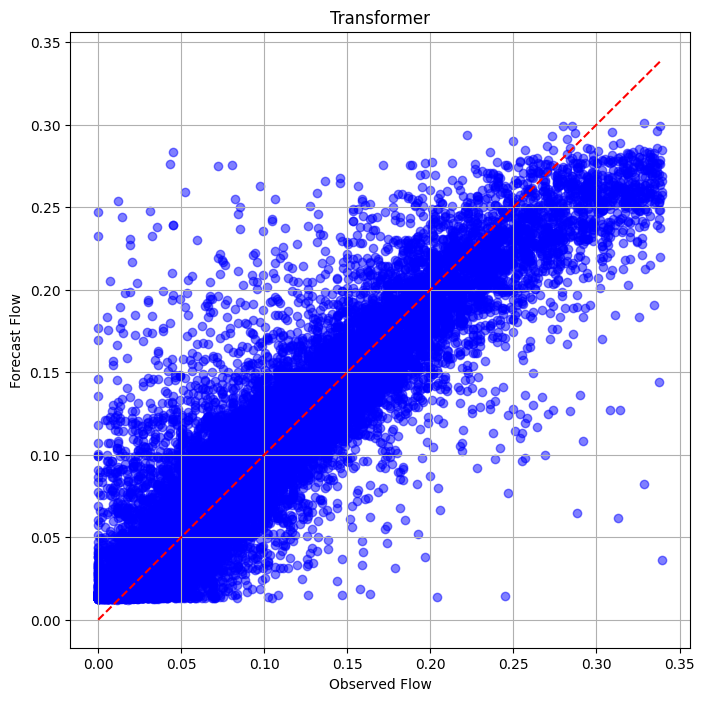

In [123]:


import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Forecast Flow')
plt.grid(True)
plt.show()


In [124]:
best_model.save('CHINA_TR.h5')


optimizer test

In [125]:

# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adamax
Learning Rate: 0.0013275332748889923


In [126]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_267: 0.21729127058942263
dropout_268: 0.21729127058942263
dropout_269: 0.34090268707621696
dropout_270: 0.34090268707621696
dropout_271: 0.1
dropout_272: 0.1
dropout_273: 0.1
dropout_274: 0.1
dropout_275: 0.1
dropout_276: 0.1
dropout_277: 0.1
dropout_278: 0.1
dropout_279: 0.1143865473343377


In [127]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 6, 'head_size': 8, 'num_heads': 15, 'ff_dim': 64, 'dropout_0': 0.21729127058942263, 'dropout_1': 0.34090268707621696, 'num_mlp_layers': 1, 'mlp_units_0': 128, 'mlp_dropout_0': 0.1143865473343377, 'optimizer': 'adamax', 'learning_rate': 0.0013275332243286827, 'mlp_units_1': 32, 'mlp_dropout_1': 0.380721015711765, 'mlp_units_2': 256, 'mlp_dropout_2': 0.12301934420071611, 'dropout_2': 0.1, 'dropout_3': 0.1, 'dropout_4': 0.1, 'dropout_5': 0.1}
Worst Hyperparameters: {'num_transformer_blocks': 6, 'head_size': 104, 'num_heads': 7, 'ff_dim': 12, 'dropout_0': 0.521916457364773, 'dropout_1': 0.1899510445113692, 'num_mlp_layers': 2, 'mlp_units_0': 160, 'mlp_dropout_0': 0.3019246341081938, 'optimizer': 'adamax', 'learning_rate': 0.005854116587307013, 'dropout_2': 0.1, 'dropout_3': 0.1, 'dropout_4': 0.1, 'dropout_5': 0.1, 'mlp_units_1': 32, 'mlp_dropout_1': 0.1}


In [25]:

# from keras.utils import plot_model
# # Visualize the model architecture and save the diagram to a file
# plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True

In [128]:

# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_267: 0.21729127058942263
dropout_268: 0.21729127058942263
dropout_269: 0.34090268707621696
dropout_270: 0.34090268707621696
dropout_271: 0.1
dropout_272: 0.1
dropout_273: 0.1
dropout_274: 0.1
dropout_275: 0.1
dropout_276: 0.1
dropout_277: 0.1
dropout_278: 0.1
dropout_279: 0.1143865473343377


In [129]:


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}")
    #, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
# all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
# all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
# mean_kge = np.mean(all_kge)
# mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.6f}")
print(f"Mean MAE: {mean_mae:.6f}")
print(f"Mean RMSE: {mean_rsme:.6f}")
print(f"Mean R^2: {mean_r2:.6f}")
# print(f"Mean kge: {mean_kge:.6f}")
# print(f"Mean nse: {mean_nse:.6f}")
print(f"Mean time: {mean_time:.6f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0007686724219046393, R^2: 0.8477190081036667, RMSE: 0.027724942234468936, MAE: 0.018722136866814416

Fold 2 - MSE: 0.0007787181508444383, R^2: 0.8431875700471095, RMSE: 0.02790552187013241, MAE: 0.01880007206195816

Fold 3 - MSE: 0.0006263614015350153, R^2: 0.8731633165184478, RMSE: 0.02502721321951398, MAE: 0.015811642746552182

Fold 4 - MSE: 0.0005884431871598603, R^2: 0.8798168944796365, RMSE: 0.024257847949887484, MAE: 0.015245256082405997

Fold 5 - MSE: 0.0006269340495825898, R^2: 0.8790298348487195, RMSE: 0.02503865111348033, MAE: 0.015774313313386447
Mean MSE: 0.000678
Mean MAE: 0.016871
Mean RMSE: 0.025991
Mean R^2: 0.864583
Mean time: 5.304682


In [130]:


# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)
     

Optimizer: Adamax
Learning Rate: 0.0013275332748889923


1033/1033 [==============================] - 7s 7ms/step


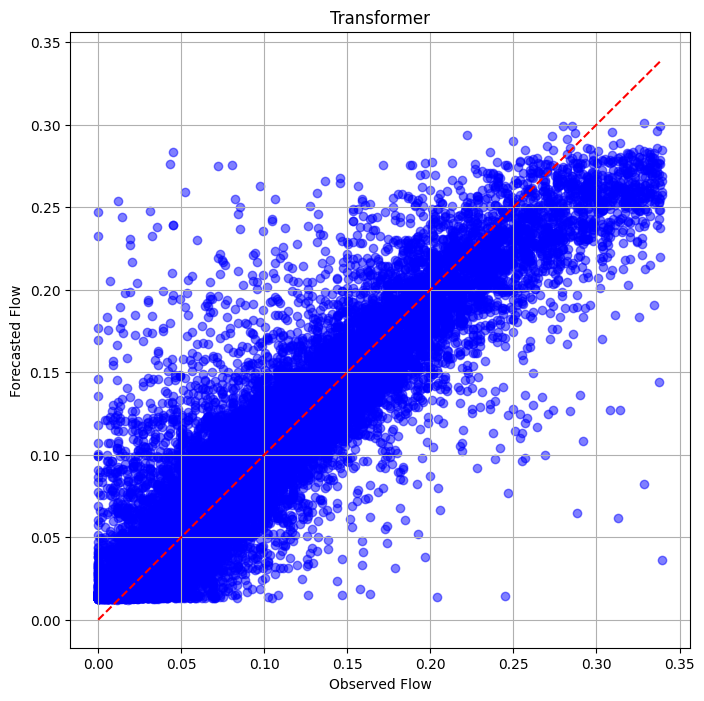

In [131]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Forecasted Flow')
plt.grid(True)
plt.show()

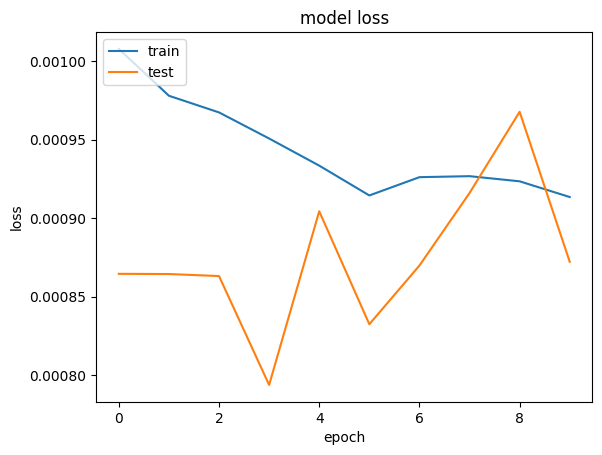

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

207/207 [==============================] - 2s 7ms/step


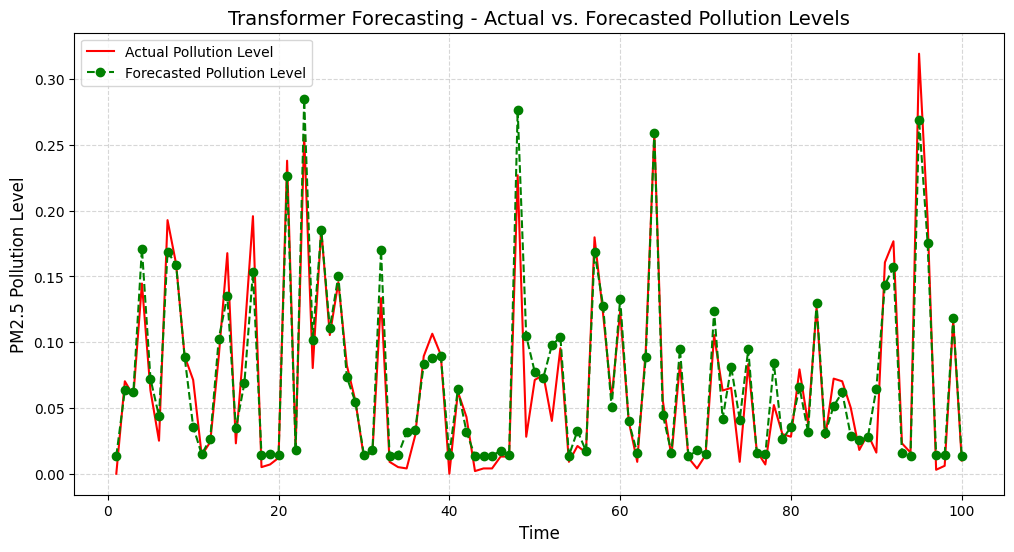

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Select 100 evenly spaced indices from the test set
num_points = 100
indices = np.linspace(0, len(y_test_outer) - 1, num_points, dtype=int)

# Subset the actual and forecasted values
time_steps = np.linspace(1, 100, num_points)  # Scale x-axis to 100 days
y_test_sampled = y_test_outer[indices]
y_pred_sampled = y_pred_best[indices]

# Define the forecasted region (last 10 points)
forecast_start = num_points - 10  # Last 10 points
forecast_x = time_steps[forecast_start:]
forecast_y_actual = y_test_sampled[forecast_start:]
forecast_y_pred = y_pred_sampled[forecast_start:]

# Plot actual pollution level in red
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test_sampled, label="Actual Pollution Level", color="red", linestyle='solid', linewidth=1.5)

# Plot forecasted pollution level in green dashed line with markers
plt.plot(time_steps, y_pred_sampled, label="Forecasted Pollution Level", color="green", linestyle='dashed', marker='o', linewidth=1.5)

# Highlight forecasted region in shaded green
# plt.axvspan(forecast_x[0], forecast_x[-1], color='green', alpha=0.2, label="Forecasted Region")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)
plt.title("Transformer Forecasting - Actual vs. Forecasted Pollution Levels", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

1/1 [==============================] - 0s 23ms/step


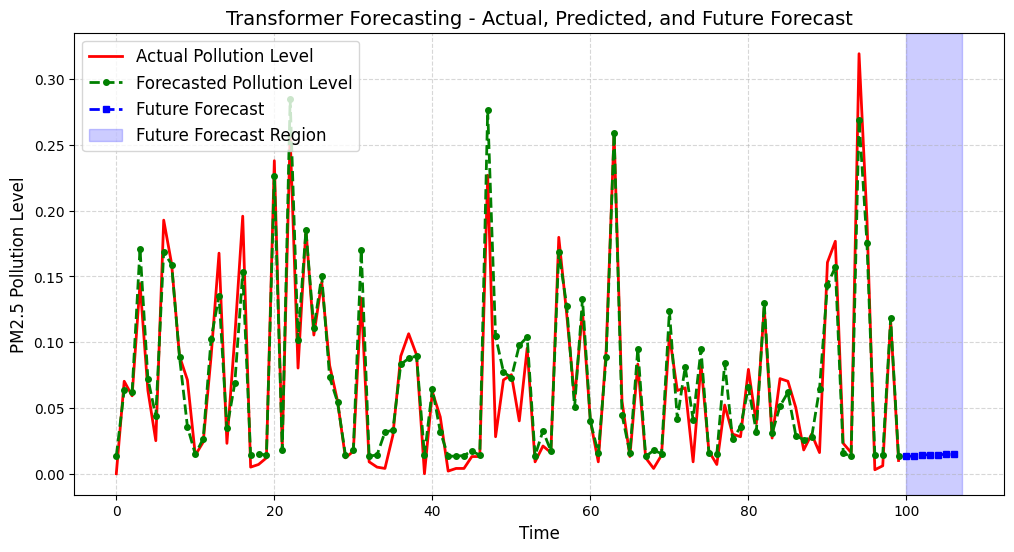

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

#Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

#Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

#Highlight the forecasted region
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

#Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

#Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

#Show the plot
plt.show()

In [135]:
#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match Transformer input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)

1/1 [==============================] - 0s 24ms/step
Forecasted PM2.5 values for the next 7 days: [0.01313178 0.01347865 0.01427412 0.01445411 0.01460755 0.01465469
 0.0146905 ]


In [136]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load the preprocessed dataset
df = pd.read_csv('original_dataset_china.csv', index_col=0)

# Define numeric columns (ensure PM2.5 is included)
numeric_columns = ['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

# Initialize and fit MinMaxScaler again on the preprocessed dataset
scaler = MinMaxScaler()
scaler.fit(df[numeric_columns])  # Fit only on the existing scaled data


MinMaxScaler()

In [137]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Ensure correct shape

# Reverse scaling only for PM2.5
scaler_pm25 = MinMaxScaler()
scaler_pm25.fit(df[['PM2.5']])  # Fit only on PM2.5 column

original_predictions = scaler_pm25.inverse_transform(future_predictions)

print("Corrected PM2.5 Values:", original_predictions.flatten())


Corrected PM2.5 Values: [16.079252 16.424736 17.21702  17.396296 17.549122 17.59607  17.631737]


In [144]:
# Convert predictions to numpy array
future_predictionss = np.array(future_predictions).reshape(-1, 1)  # Ensure correct shape

# Reverse scaling only for PM2.5
scaler_pm25 = MinMaxScaler()
scaler_pm25.fit(df[['PM2.5']])  # Fit only on PM2.5 column

original_predictionss = scaler_pm25.inverse_transform(future_predictionss)

print("Corrected PM2.5 Values:", original_predictionss.flatten())


Corrected PM2.5 Values: [16.079252 16.424736 17.21702  17.396296 17.549122 17.59607  17.631737]


In [155]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the number of future days to predict
# future_days = 7

# # Get the last time steps from the test set as input for forecasting
# input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

# # Store predictions
# future_predictions = []

# for _ in range(future_days):
#     next_pred = best_model.predict(input_data)  # Predict next time step
#     future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

#     # Update input data by shifting and adding new prediction
#     input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
#     input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# # Convert predictions to numpy array
# future_predictions = np.array(future_predictions)

# # Plot actual vs. predicted with future forecast
# plt.figure(figsize=(12, 6))
# plt.plot(y_test_outer[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
# plt.plot(y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

# # Extend time axis for future predictions
# future_time = np.arange(len(y_test_outer[:100]), len(y_test_outer[:100]) + future_days)

# # Plot future forecasted values
# plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

# # Highlight the forecasted region
# plt.axvspan(len(y_test_outer[:100]), len(y_test_outer[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

# # Improve labels and title
# plt.title("LSTM Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
# plt.xlabel("Time (Days)", fontsize=12)
# plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# # Add grid and legend
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend(loc='upper left', fontsize=12)

# # Show the plot
# plt.show()


1/1 [==============================] - 0s 35ms/step


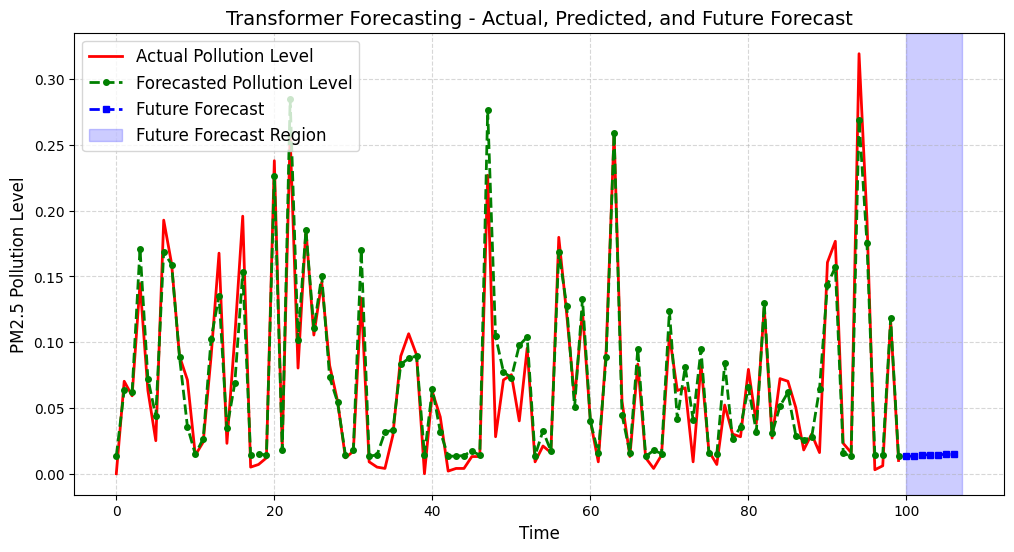

In [159]:
import numpy as np
import matplotlib.pyplot as plt

#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
# future_predictions = np.array(future_predictions)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_predictions = np.array(future_predictions)



#Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

#Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

#Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

#Highlight the forecasted region
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

#Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

#Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

#Show the plot
plt.show()

1/1 [==============================] - 0s 34ms/step


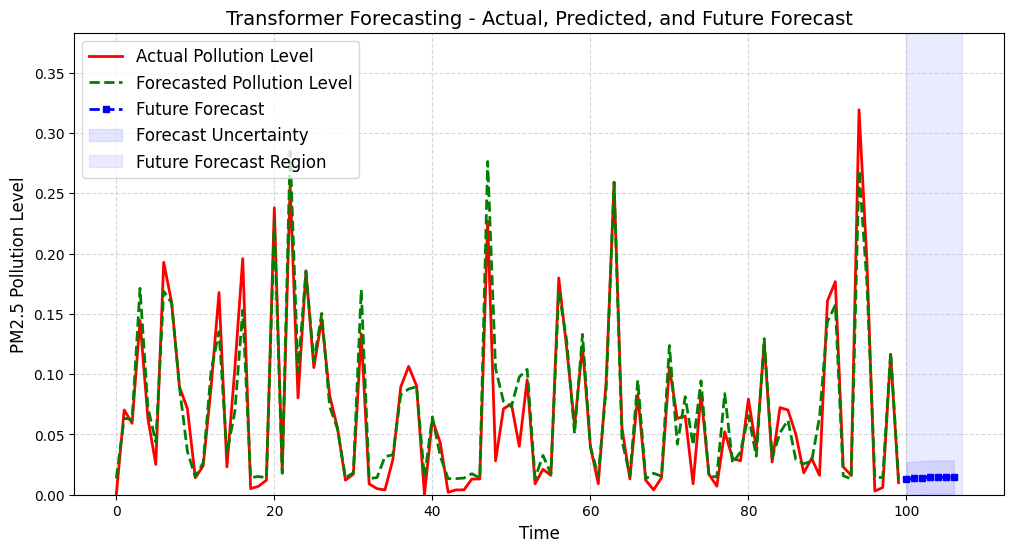

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

# Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

# Generate confidence intervals (adjust values based on model performance)
uncertainty = np.std(y_test_sampled) * 0.2  # 20% of test set standard deviation
lower_bound = future_predictions - uncertainty
upper_bound = future_predictions + uncertainty

# Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, label='Forecasted Pollution Level')

# Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

# Plot future forecasted values with better visualization
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

# Confidence interval shading
plt.fill_between(future_time, lower_bound, upper_bound, color='blue', alpha=0.1, label="Forecast Uncertainty")

# Highlight forecasted region with smoother transparency
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.08, label="Future Forecast Region")

# Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Adjust y-axis limits dynamically
plt.ylim(min(y_test_sampled[:100]) * 0.8, max(y_test_sampled[:100]) * 1.2)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


In [ ]:
# Assuming best_model is your final trained model
# best_model.save(r'C:/Users/Administrator/Documents/GitHub/AQI_Forecasting/best_model_transformer.h5')

testing for fprecasted

In [ ]:
# y_test_outer = (y_test_outer - min(y_test_outer)) / (max(y_test_outer) - min(y_test_outer))
# y_pred = (y_pred - min(y_pred)) / (max(y_pred) - min(y_pred))
# #

In [ ]:
# import numpy as np
# y_pred_smooth = np.convolve(y_pred, np.ones(3)/3, mode='same')  # Moving average


In [ ]:
# import numpy as np
# y_pred_shifted = np.roll(y_pred, shift=-1)  # Shift left by 1


1033/1033 [==============================] - 18s 17ms/step


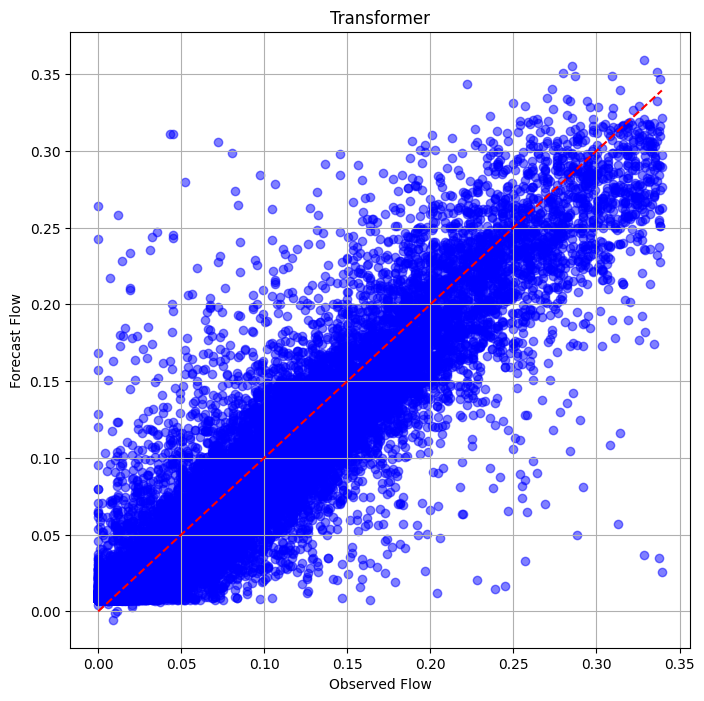

In [78]:


import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Forecast Flow')
plt.grid(True)
plt.show()


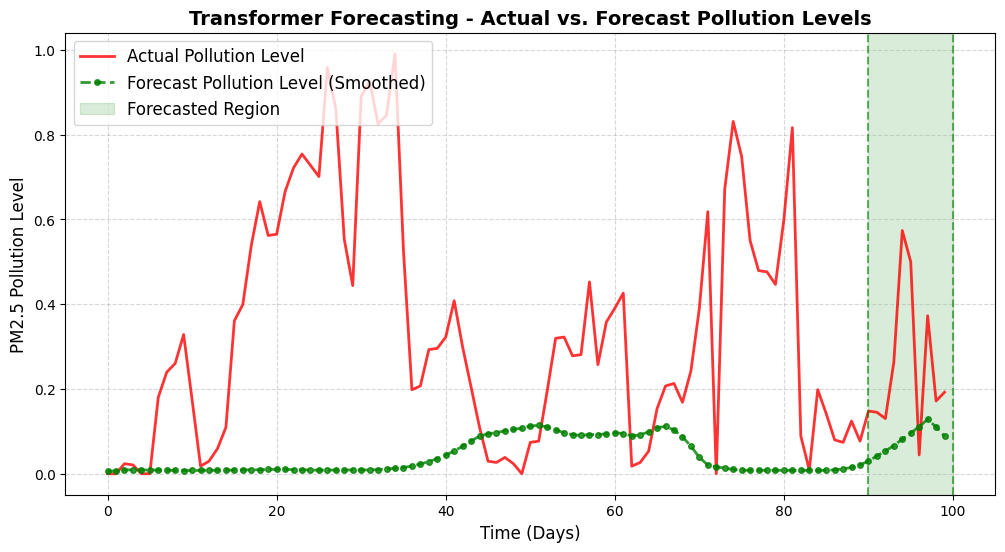

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Function to apply a moving average for smoothing
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Apply smoothing to Forecast values
y_pred_smoothed = moving_average(y_pred[:100], window_size=5)

# Increase figure size
plt.figure(figsize=(12, 6))

# Plot actual and smoothed Forecast values
plt.plot(y_test_outer[:100], color='red', linestyle='solid', linewidth=2, alpha=0.8, label='Actual Pollution Level')
plt.plot(y_pred_smoothed, color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, alpha=0.8, label='Forecast Pollution Level (Smoothed)')

# Highlight future prediction area with subtle transparency
forecast_start = len(y_test_outer[:90])
forecast_end = len(y_test_outer[:100])
plt.axvspan(forecast_start, forecast_end, color='green', alpha=0.15, label="Forecasted Region")

# Add vertical dashed lines to indicate the forecast boundary
plt.axvline(x=forecast_start, color='green', linestyle='dashed', alpha=0.6)
plt.axvline(x=forecast_end, color='green', linestyle='dashed', alpha=0.6)

# Improve labels and title
plt.title("Transformer Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14, fontweight='bold')
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Optional: Use log scale for better visibility (comment out if not needed)
# plt.yscale('log')

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust legend position outside the plot to avoid overlap
plt.legend(loc='upper left', fontsize=12, frameon=True)

# Save the improved plot (uncomment if needed)
# plt.savefig('improved_graph.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

forecasted graph testing

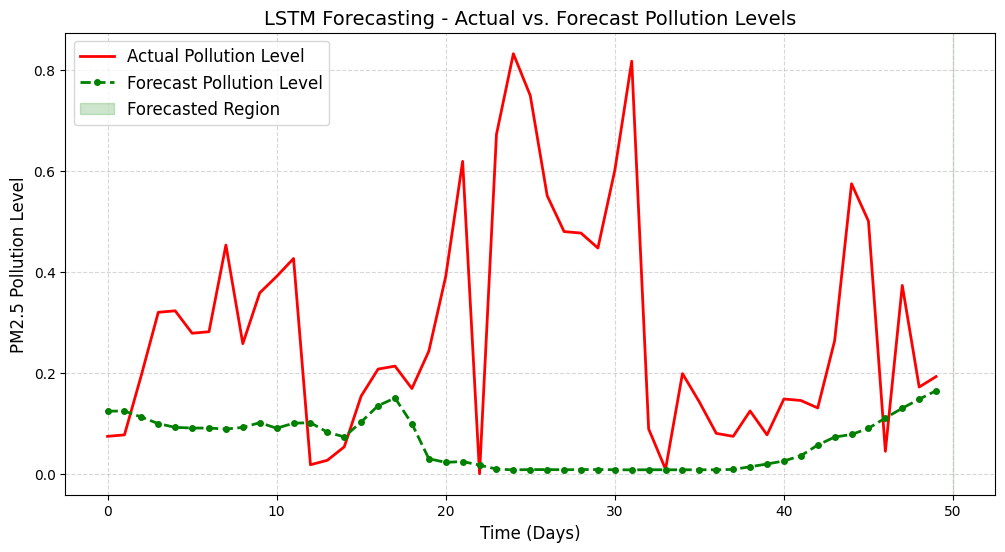

In [80]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(12, 6))

# Plot actual and Forecast values with improved styling
plt.plot(y_test_outer[50:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred[50:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecast Pollution Level')

# Highlight future prediction area
plt.axvspan(len(y_test_outer[50:100]), len(y_test_outer[50:100]), color='green', alpha=0.2, label="Forecasted Region")

# Improve labels and title
plt.title("LSTM Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust legend position
plt.legend(loc='upper left', fontsize=12)

# Save the improved plot
# plt.savefig('improved_graph.png', dpi=300)

# Show the plot
plt.show()

forecasting curve testing 2

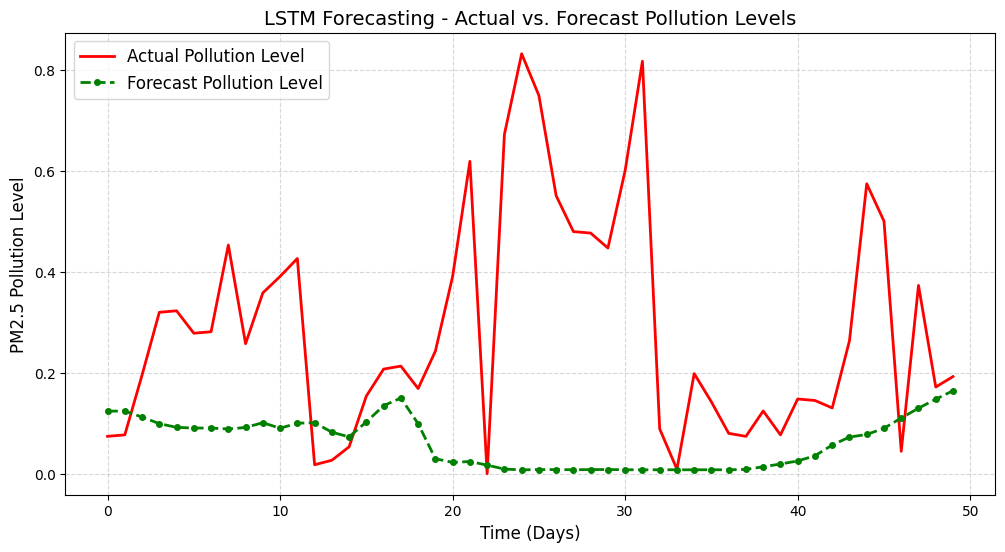

In [81]:
import matplotlib.pyplot as plt

# Increase figure size for better visibility
plt.figure(figsize=(12, 6))

# Define x-axis range for correct alignment
x_range = range(len(y_test_outer[50:100]))

# Plot actual pollution levels
plt.plot(x_range, y_test_outer[50:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')

# Plot Forecast pollution levels
plt.plot(x_range, y_pred[50:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecast Pollution Level')

# Improve labels and title
plt.title("LSTM Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust legend position
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


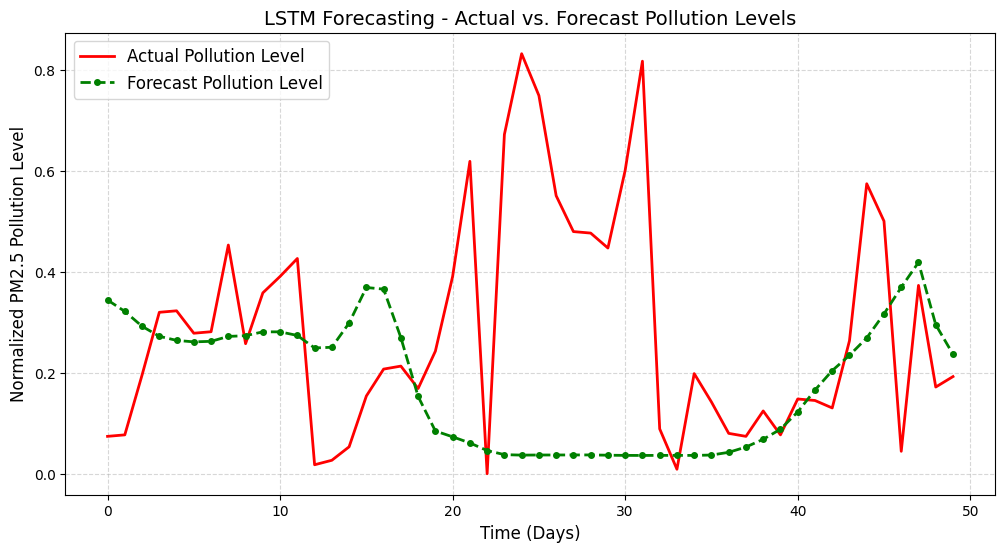

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize actual and Forecast values to the same scale
y_test_scaled = (y_test_outer[50:100] - min(y_test_outer)) / (max(y_test_outer) - min(y_test_outer))
y_pred_scaled = (y_pred[50:100] - min(y_pred)) / (max(y_pred) - min(y_pred))

# Apply moving average to smooth predictions
y_pred_smooth = np.convolve(y_pred_scaled, np.ones(3)/3, mode='same')

# Shift predictions slightly to align better
y_pred_shifted = np.roll(y_pred_smooth, shift=-1)  

# Define x-axis range for correct alignment
x_range = range(len(y_test_scaled))

# Increase figure size for better visibility
plt.figure(figsize=(12, 6))

# Plot actual pollution levels (normalized)
plt.plot(x_range, y_test_scaled, color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')

# Plot Forecast pollution levels (smoothed & shifted)
plt.plot(x_range, y_pred_shifted, color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecast Pollution Level')

# Improve labels and title
plt.title("LSTM Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Normalized PM2.5 Pollution Level", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust legend position
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


207/207 [==============================] - 4s 17ms/step


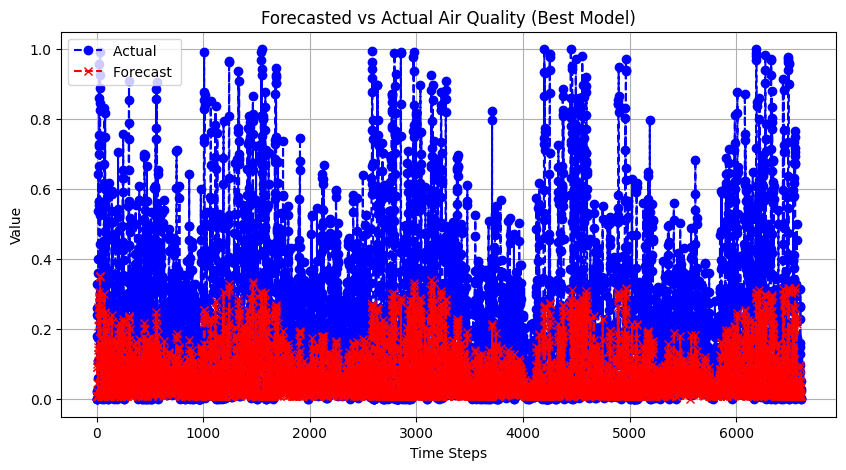

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Create time steps (adjust based on your dataset size)
time_steps = np.arange(len(y_test_outer))

# Plot actual vs Forecast values
plt.figure(figsize=(10, 5))
plt.plot(time_steps, y_test_outer, label="Actual ", color="blue", marker='o', linestyle='dashed')
plt.plot(time_steps, y_pred_best, label="Forecast ", color="red", marker='x', linestyle='dashed')

# Labels and title
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Forecasted vs Actual Air Quality (Best Model)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


207/207 [==============================] - 3s 15ms/step


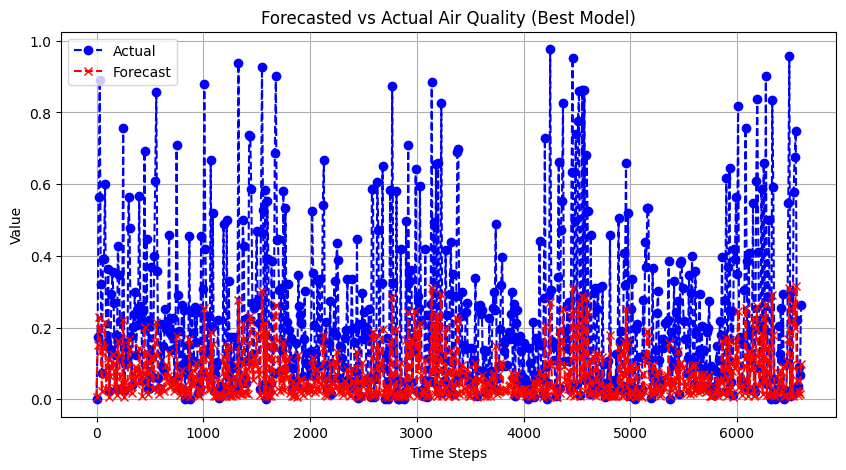

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Reduce the number of plotted points (every 10th point)
sampling_rate = 10  # Change this to control how much data to plot
time_steps = np.arange(len(y_test_outer))[::sampling_rate]
y_test_sampled = y_test_outer[::sampling_rate]
y_pred_sampled = y_pred_best[::sampling_rate]

# Plot actual vs Forecast values
plt.figure(figsize=(10, 5))
plt.plot(time_steps, y_test_sampled, label="Actual", color="blue", marker='o', linestyle='dashed')
plt.plot(time_steps, y_pred_sampled, label="Forecast", color="red", marker='x', linestyle='dashed')

# Labels and title
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Forecasted vs Actual Air Quality (Best Model)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


207/207 [==============================] - 3s 16ms/step


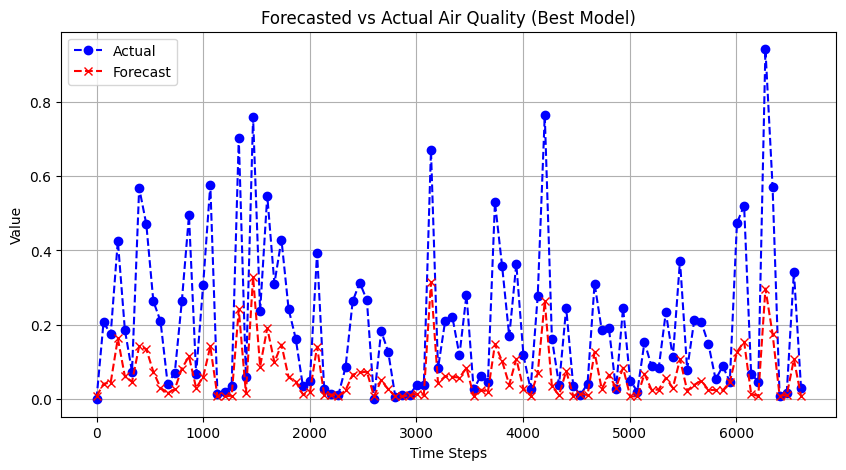

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Select 100 evenly spaced indices from the test set
num_points = 100
indices = np.linspace(0, len(y_test_outer) - 1, num_points, dtype=int)

# Subset the actual and Forecast values
time_steps = indices
y_test_sampled = y_test_outer[indices]
y_pred_sampled = y_pred_best[indices]

# Plot actual vs Forecast values
plt.figure(figsize=(10, 5))
plt.plot(time_steps, y_test_sampled, label="Actual", color="blue", marker='o', linestyle='dashed')
plt.plot(time_steps, y_pred_sampled, label="Forecast", color="red", marker='x', linestyle='dashed')

# Labels and title
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Forecasted vs Actual Air Quality (Best Model)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

207/207 [==============================] - 3s 15ms/step


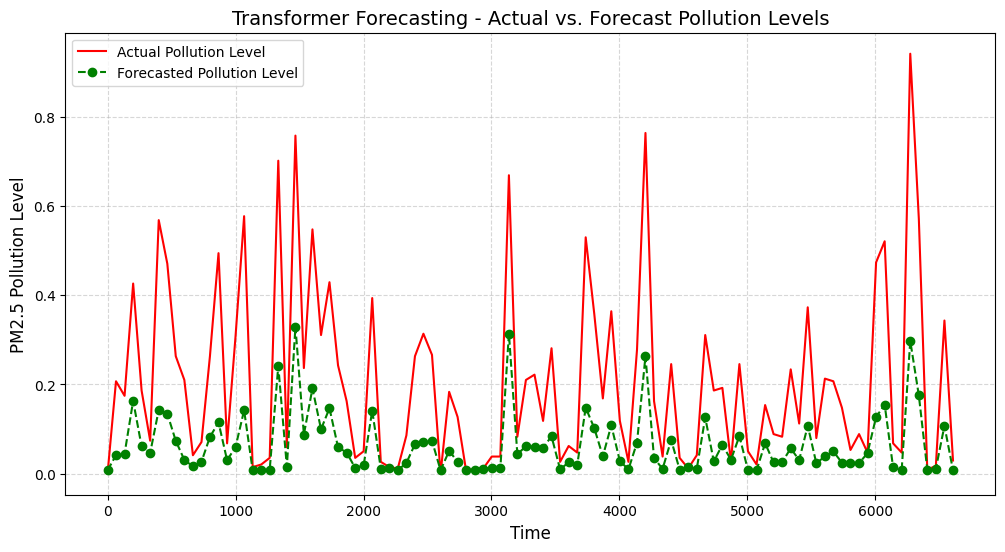

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Select 100 evenly spaced indices from the test set
num_points = 100
indices = np.linspace(0, len(y_test_outer) - 1, num_points, dtype=int)

# Subset the actual and Forecast values
time_steps = indices
y_test_sampled = y_test_outer[indices]
y_pred_sampled = y_pred_best[indices]

# Define the forecasted region (last 10 points)
forecast_start = num_points - 10  # Last 10 points
forecast_x = time_steps[forecast_start:]
forecast_y_actual = y_test_sampled[forecast_start:]
forecast_y_pred = y_pred_sampled[forecast_start:]

# Plot actual pollution level in red
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test_sampled, label="Actual Pollution Level", color="red", linestyle='solid', linewidth=1.5)

# Plot Forecast pollution level in green dashed line with markers
plt.plot(time_steps, y_pred_sampled, label="Forecasted Pollution Level", color="green", linestyle='dashed', marker='o', linewidth=1.5)

# Highlight forecasted region in shaded green
# plt.axvspan(forecast_x[0], forecast_x[-1], color='green', alpha=0.2, label="Forecasted Region")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)
plt.title("Transformer Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [87]:
#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match Transformer input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)

1/1 [==============================] - 0s 25ms/step
Forecasted PM2.5 values for the next 7 days: [0.00788375 0.00756793 0.00737872 0.00734657 0.00737022 0.00734387
 0.00737009]


In [88]:
import numpy as np

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Ensure correct input shape

# Store predictions
future_predictions = []

for _ in range(future_days):
    # Predict next time step
    next_pred = best_model.predict(input_data)

    # Extract predicted value correctly
    predicted_value = next_pred[0, 0]  # Assuming PM2.5 is at index 0

    # Store the predicted value
    future_predictions.append(predicted_value)

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = predicted_value  # Update last time step with predicted PM2.5

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

# Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)


1/1 [==============================] - 0s 31ms/step
Forecasted PM2.5 values for the next 7 days: [0.00788375 0.00756793 0.00737872 0.00734657 0.00737022 0.00734387
 0.00737009]


In [89]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load the preprocessed dataset
df = pd.read_csv('original_dataset_kathmandu.csv', index_col=0)

# Define numeric columns (ensure PM2.5 is included)
numeric_columns = ['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

# Initialize and fit MinMaxScaler again on the preprocessed dataset
scaler = MinMaxScaler()
scaler.fit(df[numeric_columns])  # Fit only on the existing scaled data


MinMaxScaler()

In [90]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Ensure correct shape

# Reverse scaling only for PM2.5
scaler_pm25 = MinMaxScaler()
scaler_pm25.fit(df[['PM2.5']])  # Fit only on PM2.5 column

original_predictions = scaler_pm25.inverse_transform(future_predictions)

print("Corrected PM2.5 Values:", original_predictions.flatten())


Corrected PM2.5 Values: [8.75761  8.446848 8.26066  8.229029 8.252298 8.226372 8.252167]


207/207 [==============================] - 4s 18ms/step


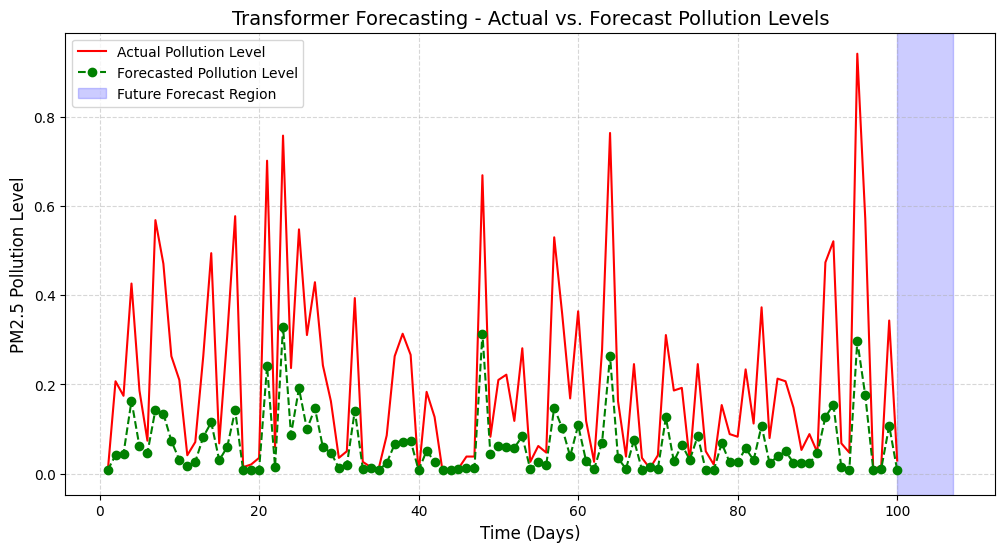

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Select only 100 data points for a clearer x-axis
num_points = 100
indices = np.linspace(0, len(y_test_outer) - 1, num_points, dtype=int)

# Subset the actual and predicted values
time_steps = np.linspace(1, 100, num_points)  # Rescale x-axis to represent 100 days
y_test_sampled = y_test_outer[indices]
y_pred_sampled = y_pred_best[indices]

# Define the forecasted region (last 10 points)
forecast_start = num_points - 10  # Last 10 points
forecast_x = time_steps[forecast_start:]
forecast_y_actual = y_test_sampled[forecast_start:]
forecast_y_pred = y_pred_sampled[forecast_start:]

# Plot actual pollution level in red
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test_sampled, label="Actual Pollution Level", color="red", linestyle='solid', linewidth=1.5)

# Plot predicted pollution level in green dashed line with markers
plt.plot(time_steps, y_pred_sampled, label="Forecasted Pollution Level", color="green", linestyle='dashed', marker='o', linewidth=1.5)

# Highlight forecasted region in shaded green
# plt.axvspan(forecast_x[0], forecast_x[-1], color='green', alpha=0.2, label="Forecasted Region")
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")


# Labels and title
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)
plt.title("Transformer Forecasting - Actual vs. Forecast Pollution Levels", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


1/1 [==============================] - 0s 24ms/step


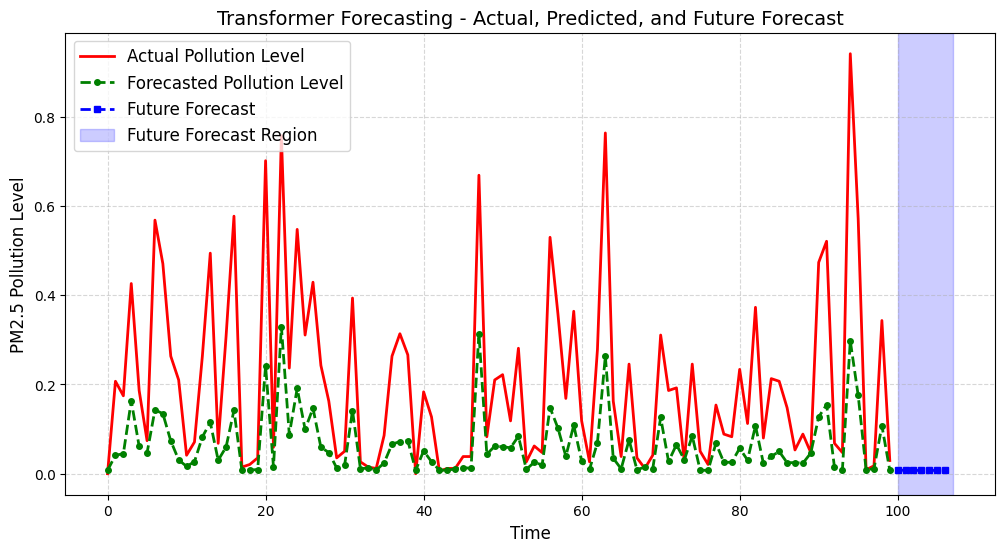

In [92]:
import numpy as np
import matplotlib.pyplot as plt

#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

#Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

#Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

#Highlight the forecasted region
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

#Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

#Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

#Show the plot
plt.show()

1/1 [==============================] - 0s 36ms/step


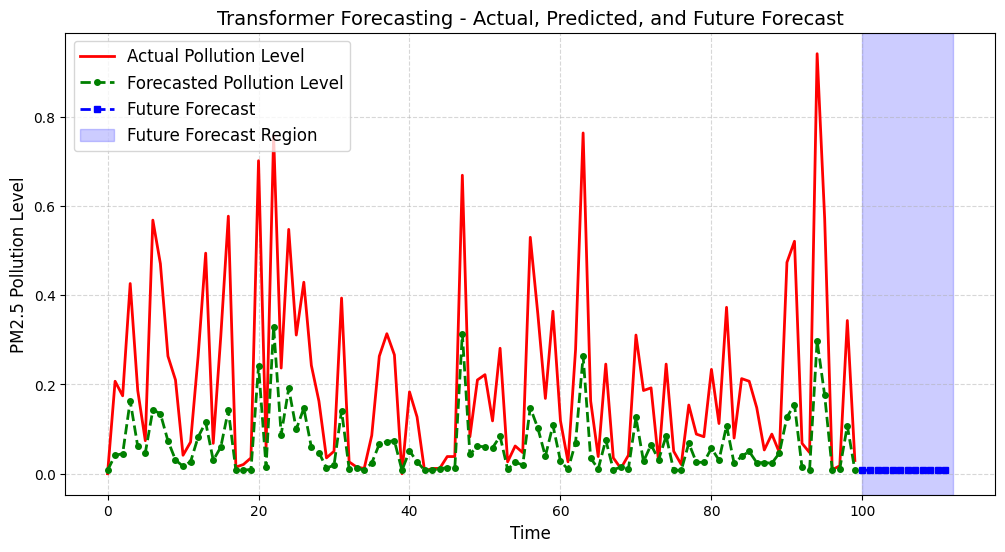

In [93]:
import numpy as np
import matplotlib.pyplot as plt

#Define the number of future days to predict
future_days = 12

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

#Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

#Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

#Highlight the forecasted region
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

#Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

#Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

#Show the plot
plt.show()